![Sentiment Analysis](Customer-survey-feedback.jpg)

# Problem Statement 
The lack of comprehensive understanding of public sentiment towards Google and Apple brands presents a significant challenge for our tech firm specializing in these companies' products. By analyzing customer feedback expressed on Twitter, we aim to identify specific areas for improvement in Google and Apple products and services. Ultimately, this analysis will empower **Best Buy** to make strategic decisions that enhance customer satisfaction and bolster the market competitiveness of both Google and Apple products.
In today's digital age, social media platforms like Twitter serve as a valuable source of public opinion and customer feedback, offering insights that can drive strategic decision-making for businesses.

As a consulting firm commissioned by Best Buy, our objective is to develop a robust model capable of analyzing tweet content to accurately assess sentiment towards Apple and Google products. This model will effectively categorize tweets into positive, negative, or neutral sentiments, providing valuable insights into public perception. These insights will be utilized to inform strategic business decisions and enhance customer satisfaction across enterprises in **Best Buy**. Additionally, the marketing team can leverage these insights to gauge public sentiment towards Apple and Google products on social media. By analyzing tweets, they can understand how customers perceive these brands and their products, identify areas for improvement, and capitalize on positive sentiment for targeted marketing campaigns.

# Objectives
1. **Understanding Public Opinion:** 
    Gain insights into public sentiment towards Google and Apple brands as discussed on Twitter.
2. **Customer Feedback Analysis:** 
    Analyze customer feedback expressed on Twitter to identify areas for improvement for Google and Apple products and services and enhance customer satisfaction.
3.  **Market Research:** 
    Use sentiment analysis to gather market intelligence, understand consumer preferences, and identify emerging trends in real-time. 
4. **Competitive Analysis:** 
    Compare the sentiment surrounding Google and Apple brands, as competitors, to inform strategic decision-making.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import re
from string import punctuation

#scipy
from scipy.sparse import csr_matrix

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC

#xgboost
import xgboost as xgb

#nlkt
from nltk import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

import joblib

In [2]:
# Define color map for plots
# Import color map
import matplotlib.cm as cm
# Choose a predefined colormap
colormap = cm.coolwarm  # Choose a diverging colormap like 'coolwarm', 'RdBu', 'seismic', etc.

# Create a color array with a range of colors from the chosen colormap
color_array = [colormap(i) for i in range(20)]  # Choose 20 colors from the palette

# Set the default color cycle to the color array
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_array)

In [3]:
# Load data and check structure 
data = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
# Checking data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


# Data Cleaning

In [5]:
# Check missing values
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
# Checking index of missing value in tweet column
data[data['tweet_text'].isna()].index

Index([6], dtype='int64')

In [7]:
# Dropping the row above with missing value in tweet_text
data.drop(index=data[data['tweet_text'].isna()].index, inplace= True)

In [8]:
# Shorten column names
data.columns = ['tweet', 'brand_product', 'emotion']

In [9]:
# Change emotions to 'Positive', 'Negative', and 'Neutral'
data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
data.loc[data['emotion'] == 'Positive emotion', 'emotion'] = 'Positive'
data.loc[data['emotion'] == 'Negative emotion', 'emotion'] = 'Negative'

In [10]:
# Checking value counts for brand_product column
data.brand_product.value_counts()

brand_product
iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: count, dtype: int64

In [11]:
# Derive 'brand_product' from tweets to fill missing values in former column
categories = np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android'])
def fill_missing_brand_product(df, categories):
    for i, row in df.iterrows():
        if pd.isnull(row['brand_product']):
            for category in np.concatenate((categories, np.char.lower(categories))):
                if category in row['tweet']:
                    # Use .loc[] to assign values to DataFrame
                    data.loc[i, 'brand_product'] = category
                    break  # Break out of inner loop once a category is found
                    
                    
# Call the function and pass the DataFrame 'data' and 'categories'
fill_missing_brand_product(data, categories)

In [12]:
# Check missing values, again
data.isna().sum()

tweet              0
brand_product    787
emotion            0
dtype: int64

In [13]:
# Percentage missing data for brand_product column
787/len(data)

0.09025229357798165

In [14]:
# Drop rows with missing data
data.dropna(inplace= True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive
8717,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral
8718,"Google's Zeiger, a physician never reported po...",Google,Neutral
8719,Some Verizon iPhone customers complained their...,iPhone,Neutral


In [15]:
# Check for duplicate entries
data.duplicated().sum()

20

In [16]:
#Remove duplicates
data.drop_duplicates(inplace=True)

emotion
Neutral         4381
Positive        2845
Negative         543
I can't tell     144
Name: count, dtype: int64


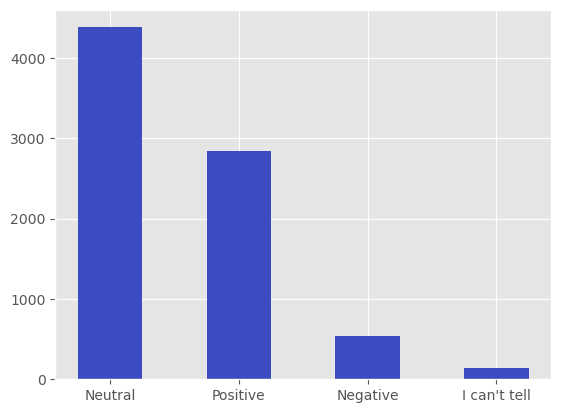

In [17]:
# Check classes for target feature
print(data.emotion.value_counts())
plt.bar(data.emotion.value_counts().index, data.emotion.value_counts(), width=.5);

In [18]:
# Drop rows where emotion is 'I can't tell'
data.drop(index=data[data['emotion'] == 'I can\'t tell'].index, inplace= True)
data.reset_index(drop=True, inplace=True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
7764,Ipad everywhere. #SXSW {link},iPad,Positive
7765,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral
7766,"Google's Zeiger, a physician never reported po...",Google,Neutral
7767,Some Verizon iPhone customers complained their...,iPhone,Neutral


In [19]:
# drop index 7768 with wierd characters
data.drop(index=7768, inplace= True)

In [20]:
# View full text on sample tweets
data[['tweet']].sample(10).style.set_properties(**{'text-align': 'left'})

,tweet
1749,@mention Apple store NYC one day? #SXSW
2288,Get to the nav schemes I am done with the iPad shape lesson #sxsw
1051,Listening to Marissa Mayer's sales shpeal on google everything #hotwhat? #sxsw
1597,"has an ipad 2 in his hands, and it is exquisite. #sxsw"
7057,Better get in line now. RT @mention Apple is opening up a temp store in downtown Austin for #SXSW & iPad 2 launch {link}
358,Among the cool/goofy things I've spied at #SxSW today - iPad case made to look like an EtchnSketch; grown up game of tug o' war.
2870,Taken with an iPhone #SXSW {link}
4727,"RT @mention At #SXSW, Apple schools the marketing experts {link} via @mention"
4996,RT @mention Google is NOT launching any products at #SXSW {link}
4766,RT @mention Best pickup-line at #SXSW: Do you have an iPhone charger?


# Train test split

In [24]:
#Perform a train test split on data
X = data[['tweet', 'brand_product']]
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1)
X_train

,tweet,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...",Google
5953,RT @mention Who is flying to #SXSW and wants s...,iPhone
2532,Ha! Another mention for Apple Store: {link} - ...,Apple
2481,;-) RT @mention @mention The geeks need somewh...,iPad
2652,This stuff is great. Love seeing how these guy...,Other Google product or service
...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Apple
5192,RT @mention I hope everyone has an awesome wee...,Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,iPad
235,"#technews Apple heads to SXSW, sets up tempora...",iPad


# Data preprocessing

In [25]:
# Function to remove tweet handles(words that start with @), HTML tags and URLs in tweets
def remove_html_urls_mentions(input_text):
    # Remove HTML tags
    pattern_html = re.compile('<.*?>')
    text = pattern_html.sub(r'', input_text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove Twitter usernames (mentions)
    text = re.sub(r'@\w+\s*', '', text)
    
    # Remove 'RT' (Retweet terms)
    text = re.sub(r'\bRT\b', '', text)
    
    # Remove words within curly braces {} and the braces themselves
    text = re.sub(r'\{[^}]*\}', '', text)
    
    # Remove words within square brackets [] and the brackets themselves
    text = re.sub(r'\[[^]]*\]', '', text)
    
    # Remove words within parentheses () and the parentheses themselves
    text = re.sub(r'\([^)]*\)', '', text)
    
    # Define the pattern to match any non-alphanumeric characters
    pattern = r'[^a-zA-Z0-9\s]'  # This pattern matches any character that is not a letter, digit, or whitespace

    # Replace all non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text

In [26]:
# Function to encode emojis
def encode_emojis(text):
    """
    Encode emojis in text using Unicode.

    Parameters:
    text (str): Input text containing emojis.

    Returns:
    str: Text with emojis encoded using Unicode.
    """
    # Encode emojis using Unicode escape sequences
    emoji_encoded_text = text.encode('unicode-escape').decode('utf-8')
    
    return emoji_encoded_text

In [27]:
# Clean tweets for X_train data
X_train['cleaned_tweet'] = X_train['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))
X_train = X_train[['tweet', 'cleaned_tweet', 'brand_product']].copy()
X_train

,tweet,cleaned_tweet,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...",In the Google keynote Marissa Meyer and some o...,Google
5953,RT @mention Who is flying to #SXSW and wants s...,Who is flying to SXSW and wants some free mil...,iPhone
2532,Ha! Another mention for Apple Store: {link} - ...,Ha Another mention for Apple Store Temporar...,Apple
2481,;-) RT @mention @mention The geeks need somewh...,The geeks need somewhere downtown to line up...,iPad
2652,This stuff is great. Love seeing how these guy...,This stuff is great Love seeing how these guys...,Other Google product or service
...,...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Love it From Apple to Naomi Campbell popup s...,Apple
5192,RT @mention I hope everyone has an awesome wee...,I hope everyone has an awesome weekend at SXS...,Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,Apple Opening PopUp Store in Austin for SXSW ...,iPad
235,"#technews Apple heads to SXSW, sets up tempora...",technews Apple heads to SXSW sets up temporary...,iPad


In [28]:
# Clean tweets for X_test data
X_test['cleaned_tweet'] = X_test['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))
X_test = X_test[['tweet', 'cleaned_tweet', 'brand_product']].copy()
X_test

,tweet,cleaned_tweet,brand_product
3192,the @mention booth is up and ready for the #sx...,the booth is up and ready for the sxsw tradesh...,Android
605,@mention iPhone. Clearly. Positively. Happily...,iPhone Clearly Positively Happily SXSW,iPhone
5027,RT @mention Google tested 41 shades of blue fo...,Google tested 41 shades of blue for link colo...,Google
7414,Google &quot;product gatekeeper&quot; Marissa ...,Google quotproduct gatekeeperquot Marissa Maye...,Google
311,will this be another google wave? RT @mention ...,will this be another google wave We interrupt...,google
...,...,...,...
2753,@mention getting his new iPad at the #sxsw fla...,getting his new iPad at the sxsw flash apple s...,iPad
6041,Hotpot #google #marissameyer what is next #Cle...,Hotpot google marissameyer what is next Clevel...,google
5954,"RT @mention Who said IPAD photos? Apple Store,...",Who said IPAD photos Apple Store SXSW,Apple
5706,RT @mention RT: @mention With 150 million mobi...,With 150 million mobile users on Google maps...,Google


## Exploratory Data Analysis

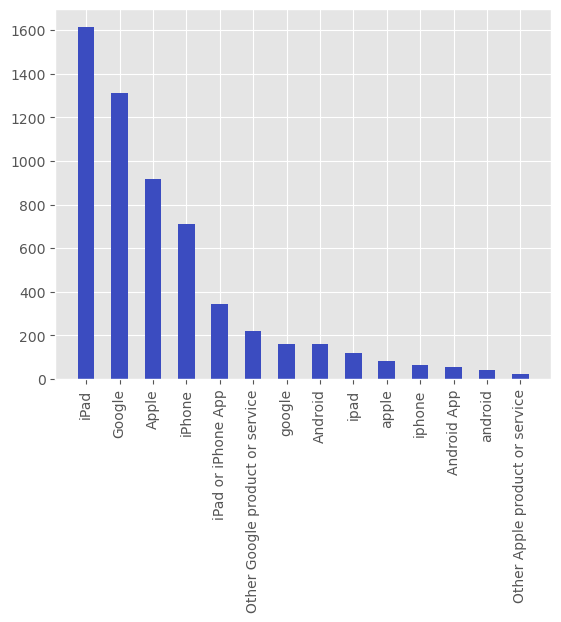

In [29]:
# EDA
X_train['brand_product'].value_counts()
plt.bar(X_train['brand_product'].value_counts().index, X_train['brand_product'].value_counts(), width=.5)
plt.xticks(rotation=90);

In [30]:
# Merge brand_column into only two categories: apple and google brands
Apple = ['iPad', 'Apple', 'iPhone', 'iPad or iPhone App', 'ipad', 'apple', 'iphone', 'Other Apple product or service']
Google = ['Google', 'google', 'Other Google product or service', 'Android', 'Android App', 'android']

def brand_category(X):
    for index, row in X.iterrows():
        if row['brand_product'] in Apple:
            X.at[index, 'brand_product'] = 'Apple'
        elif row['brand_product'] in Google:
            X.at[index, 'brand_product'] = 'Google'
    
    return X

# Call function on X_train data
X_train = brand_category(X_train)

In [31]:
# Call function on X_test data
X_test = brand_category(X_test)

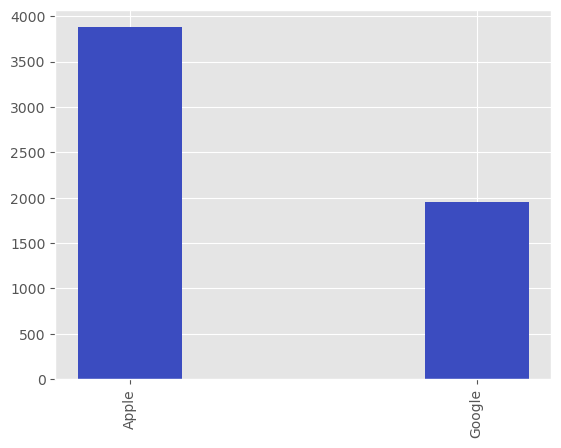

In [32]:
# Re-check brand_product column
X_train['brand_product'].value_counts()
plt.bar(X_train['brand_product'].value_counts().index, X_train['brand_product'].value_counts(), width=.3)
plt.xticks(rotation=90);

In [33]:
# Function to tokenize and remove stopwords and punctuation
def process_tweet(tweet):
    tweet = tweet.lower() #convert tweet to lowercase
    # Define a regular expression pattern to match words including apostrophes
    pattern = r"\b\w+(?:'\w+)?\b"
    # Create a RegexpTokenizer with the defined pattern
    tokenizer = RegexpTokenizer(pattern)
    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token for token in tokens if token not in stopwords.words('english') 
              and token not in punctuation]                                    #remove stopwords and punctuations
    return tokens

# Apply function on X_train and X_test data
X_train['tokenized_tweets'] = X_train['cleaned_tweet'].apply(process_tweet)
X_test['tokenized_tweets'] = X_test['cleaned_tweet'].apply(process_tweet)

In [34]:
# Change columns arrangements
X_train = X_train[['tweet', 'cleaned_tweet', 'tokenized_tweets', 'brand_product']]
X_test = X_test[['tweet', 'cleaned_tweet', 'tokenized_tweets', 'brand_product']]

In [35]:
# Generate Frequency distribution
FreqDist(X_train['tokenized_tweets'].explode())

FreqDist({'sxsw': 6053, 'ipad': 1716, 'google': 1565, 'apple': 1423, 'iphone': 1061, 'store': 985, 'new': 752, '2': 739, 'austin': 601, 'app': 544, ...})

##### Top 20 tokens distribution

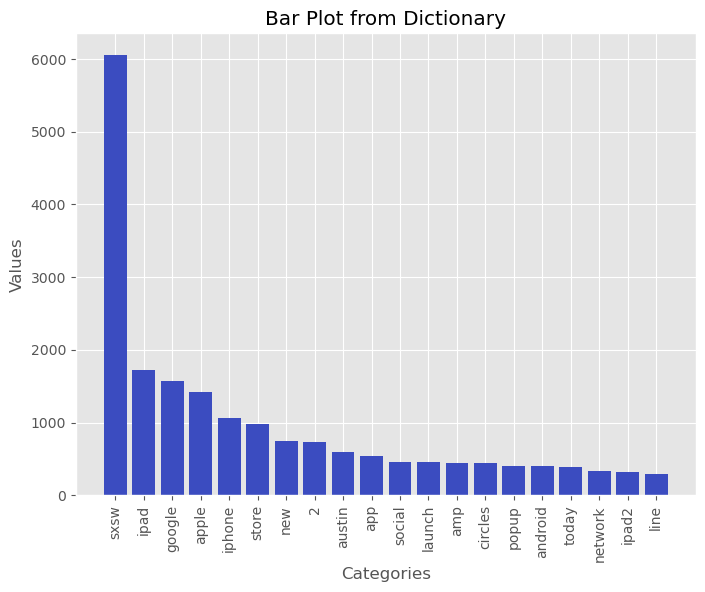

In [36]:
# Extract top 20 tokens and their values 
top_20 = FreqDist(X_train['tokenized_tweets'].explode()).most_common(20)
categories, values = zip(*top_20)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot from Dictionary')
plt.xticks(rotation=90)
plt.show()

##### Token distribution by brand [@Top 20]

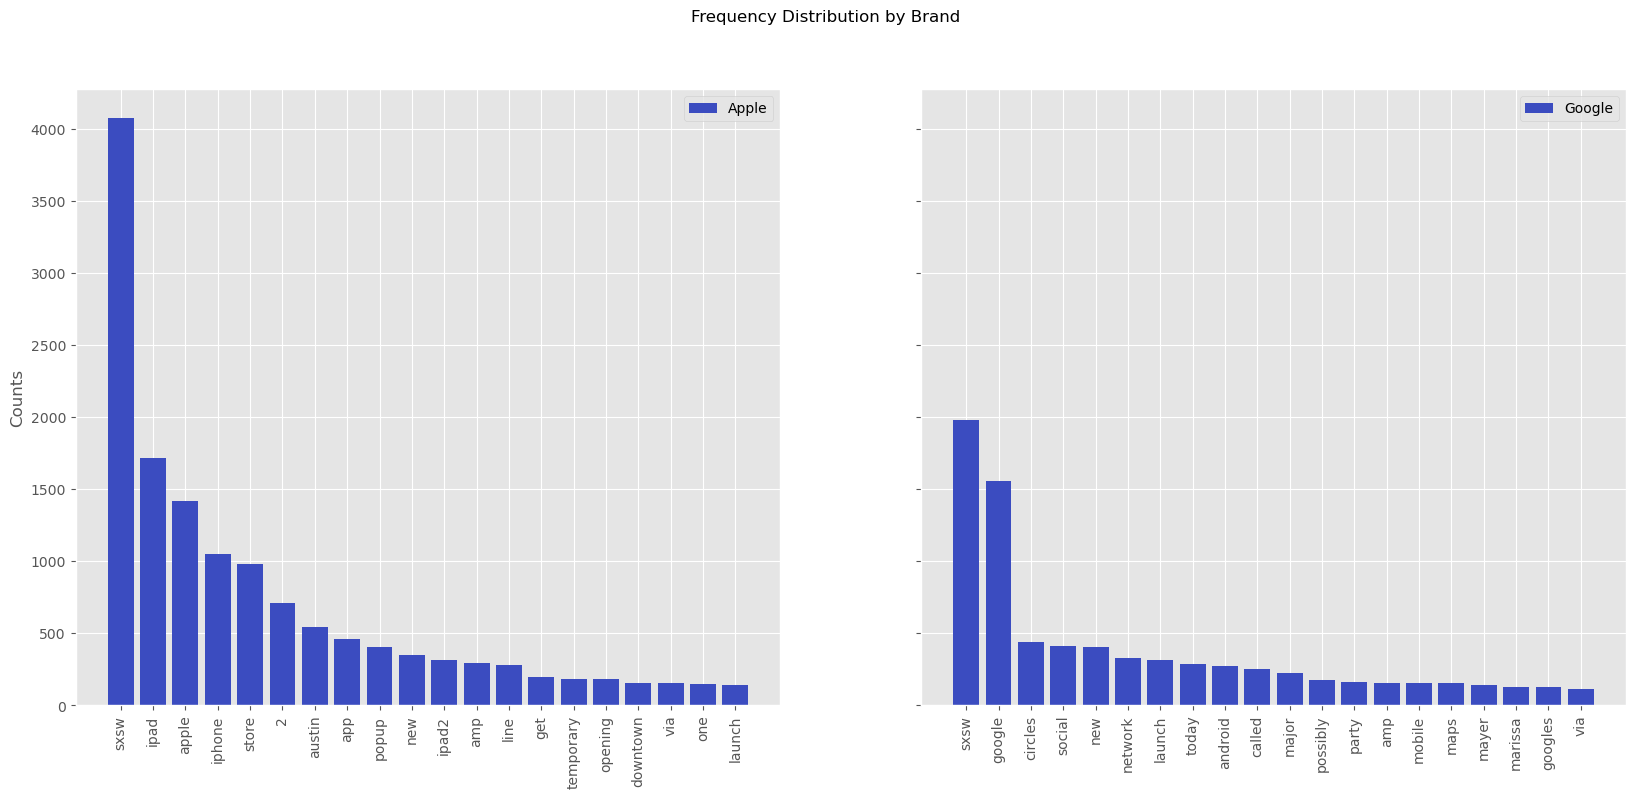

In [37]:
#check distribution by brand category
for_eda = pd.concat([X_train,y_train], axis= 1)
apple = for_eda[for_eda['brand_product'] == 'Apple']
google = for_eda[for_eda['brand_product'] == 'Google']

# Extract top 20 tokens and their values for apple brand
apple_top_20 = FreqDist(apple['tokenized_tweets'].explode()).most_common(20)
apple_categories, apple_values = zip(*apple_top_20)

# Extract top 20 tokens and their values for google brand
google_top_20 = FreqDist(google['tokenized_tweets'].explode()).most_common(20)
google_categories, google_values = zip(*google_top_20)

# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(apple_categories, apple_values, label='Apple')
axes[1].bar(google_categories, google_values, label='Google')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Brand')
axes[0].set_xticks(range(len(apple_categories)))
axes[0].set_xticklabels(apple_categories, rotation=90) 
axes[1].set_xticks(range(len(google_categories)))
axes[1].set_xticklabels(google_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

##### Emotions/Sentiments class distribution by brand

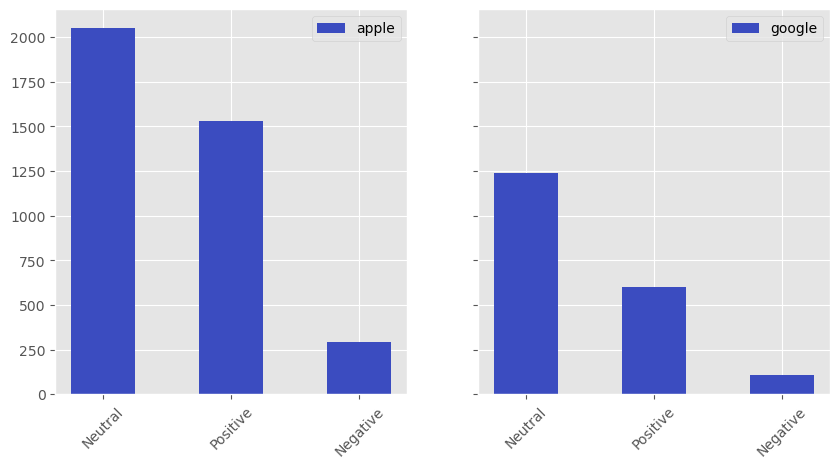

In [38]:
# Sentiments by brand
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize= (10, 5), sharey= True)
ax[0].bar(apple['emotion'].value_counts().index, apple['emotion'].value_counts(), width= .5, label='apple');
ax[1].bar(google['emotion'].value_counts().index, google['emotion'].value_counts(), width= .5, label= 'google')
ax[0].legend()
ax[1].legend()

for axis in ax:
    axis.tick_params(axis='x', rotation=45)
    
plt.show()

##### Token distribution by Emotions/Sentiments class

In [39]:
### Check token distribution based on emotion
positive_emotions_data = for_eda[for_eda['emotion'] == 'Positive']
negative_emotions_data = for_eda[for_eda['emotion'] == 'Negative']

# Extract top 20 tokens and their values for apple brand
positive_top_20 = FreqDist(positive_emotions_data['tokenized_tweets'].explode()).most_common(20)
positive_categories, positive_values = zip(*positive_top_20)

# Extract top 20 tokens and their values for google brand
negative_top_20 = FreqDist(negative_emotions_data['tokenized_tweets'].explode()).most_common(20)
negative_categories, negative_values = zip(*negative_top_20)

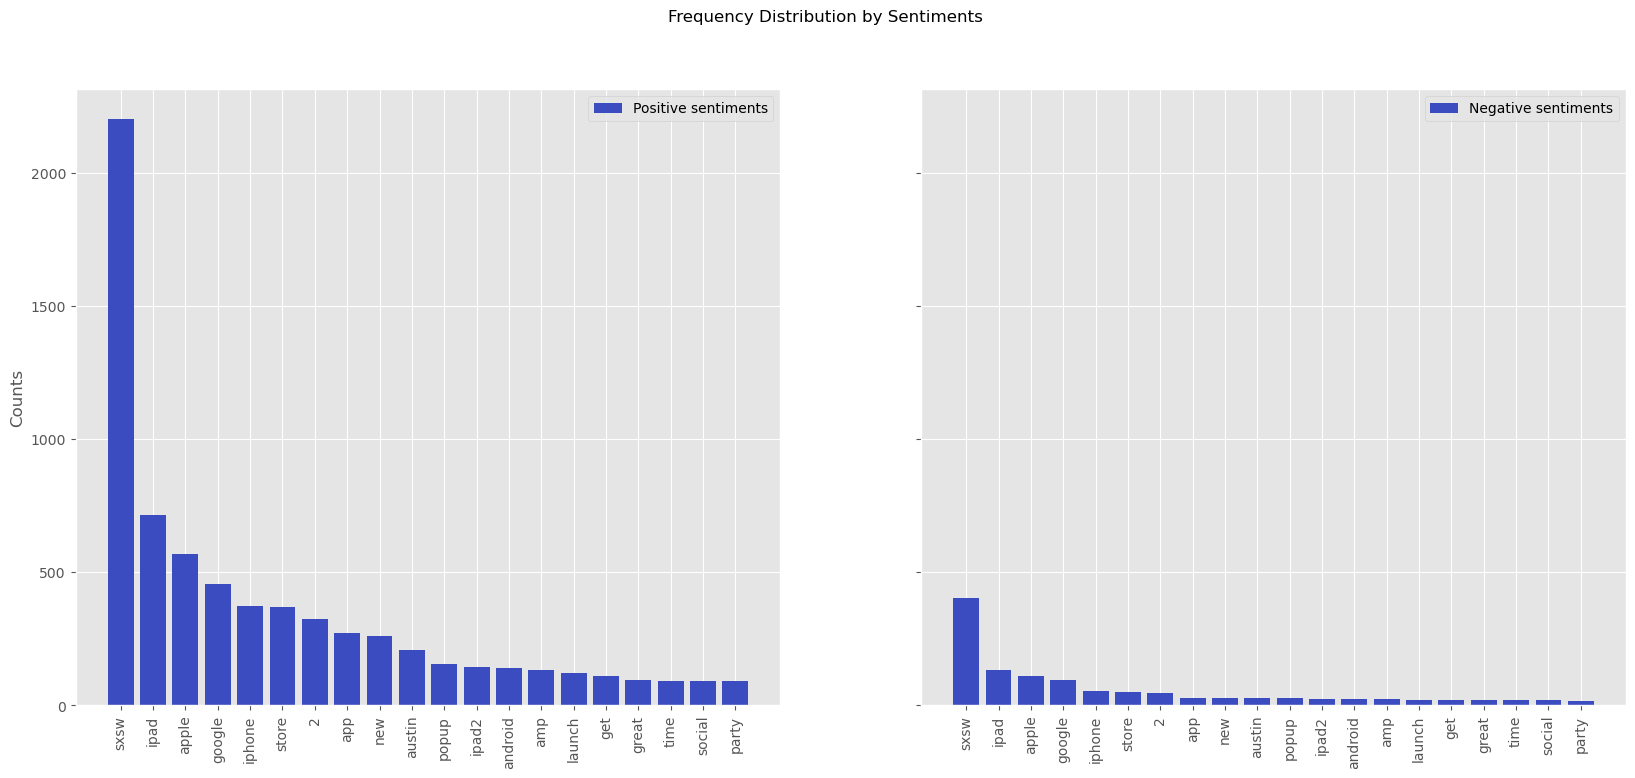

In [40]:
# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(positive_categories, positive_values, label='Positive sentiments')
axes[1].bar(negative_categories, negative_values, label='Negative sentiments')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Sentiments')
axes[0].set_xticks(range(len(positive_categories)))
axes[0].set_xticklabels(positive_categories, rotation=90) 
axes[1].set_xticks(range(len(positive_categories)))
axes[1].set_xticklabels(positive_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

##### Word Cloud representation

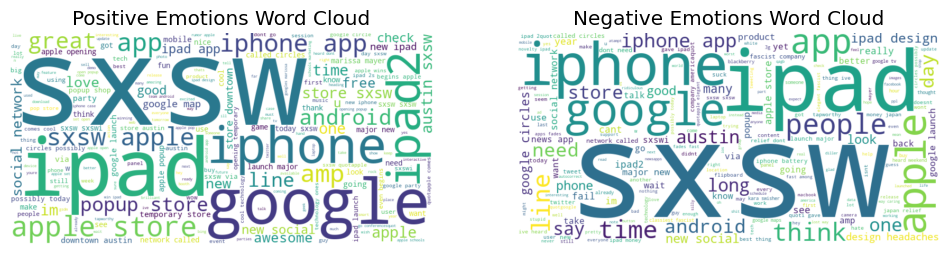

In [41]:
# Combine tokenized tweets into text strings
positive_text = ' '.join(positive_emotions_data['tokenized_tweets'].explode())
negative_text = ' '.join(negative_emotions_data['tokenized_tweets'].explode())

# Create word clouds for positive and negative emotions
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Emotions Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Emotions Word Cloud')
plt.axis('off')

plt.show()

# Data Preprocessing

## Feature Engineering

### Vectorization with TfidfVectorizer

##### Using RegexpTokenizer with TfidfVectorizer

In [42]:
# Instantiate vectorizer
stops = stopwords.words('english') + list(punctuation)
tfidf_regex = TfidfVectorizer(
    tokenizer = lambda text: RegexpTokenizer(r"\b\w+(?:'\w+)?\b").tokenize(text),
    stop_words= stops,
    max_df = .67, # Ignore terms with document frequency higher than 2/3
    max_features = 5000
                    )

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf_regex = tfidf_regex.fit_transform(X_train['cleaned_tweet'])

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
# View
X_train_tfidf_regex

<5826x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 51895 stored elements in Compressed Sparse Row format>

##### Using Lemmatizer with TfidfVectorizer

In [44]:
# Tokenization with Lemmatization function
def tokenize_and_lemmatize(text):
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")
    tokens = tokenizer.tokenize(text)  # Tokenization
    # Instantiate WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return lemmatized_tokens

In [45]:
# Initialize TfidfVectorizer with lemmatization
tfidf_lem = TfidfVectorizer(
    tokenizer = tokenize_and_lemmatize,
    stop_words= stops,
    max_df = .67,     # Ignore terms with document frequency higher than 2/3
    max_features = 5000
                    )

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf_lem = tfidf_lem.fit_transform(X_train['cleaned_tweet'])

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [46]:
# Visually inspect X_train_tfidf_regex
X_train_tfidf_regex = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_regex, 
                                                        columns=tfidf_regex.get_feature_names_out())
X_train_tfidf_regex

,1,10,100,1000,100s,101,1030,105,10k,11,...,zimride,zing,zinio,zip,zms,zombies,zomg,zone,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Visually inspect X_train_tfidf_lem
X_train_tfidf_lem = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_lem, 
                                                        columns=tfidf_lem.get_feature_names_out())
X_train_tfidf_lem

,1,10,100,1000,101,1030,105,10k,11,1130,...,zimride,zing,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### OneHotEncode brand_product column

In [48]:
#Instantiate encoder class
ohe = OneHotEncoder()

#Fit transform X_train's brand_product column
brand_product_ohe = ohe.fit_transform(X_train[['brand_product']])
brand_product_ohe = pd.DataFrame.sparse.from_spmatrix(brand_product_ohe, 
                                                      columns= ohe.get_feature_names_out())
# View
brand_product_ohe

,brand_product_Apple,brand_product_Google
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
...,...,...
5821,1.0,0.0
5822,1.0,0.0
5823,1.0,0.0
5824,1.0,0.0


In [49]:
# Append encoded brand column to X_train_tfidf_regex & X_train_tfidf_lem
X_train_final_regex = pd.concat([X_train_tfidf_regex, brand_product_ohe], axis= 1)
X_train_final_lem = pd.concat([X_train_tfidf_lem, brand_product_ohe], axis= 1)

# Baseline Model

### Naive Bayes

##### regex data

In [52]:
# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Fit to data
baseline_nb.fit(X_train_final_regex, y_train)

# Evaluate accuracy of the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_regex, y_train)['test_score']
baseline_cv_nb

array([0.635506  , 0.64549356, 0.63175966, 0.61545064, 0.65751073])

In [54]:
# Print metrics
print(classification_report(y_train, baseline_nb.predict(X_train_final_regex)))

              precision    recall  f1-score   support

    Negative       0.90      0.02      0.04       396
     Neutral       0.73      0.95      0.82      3295
    Positive       0.83      0.58      0.68      2135

    accuracy                           0.75      5826
   macro avg       0.82      0.52      0.52      5826
weighted avg       0.78      0.75      0.72      5826



##### lemmitized data

In [55]:
# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Fit to data
baseline_nb.fit(X_train_final_lem, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_lem, y_train)['test_score']
baseline_cv_nb

array([0.63464837, 0.64206009, 0.6223176 , 0.61201717, 0.65150215])

In [56]:
# Print metrics
print(classification_report(y_train, baseline_nb.predict(X_train_final_lem)))

              precision    recall  f1-score   support

    Negative       0.90      0.02      0.04       396
     Neutral       0.72      0.96      0.82      3295
    Positive       0.83      0.57      0.67      2135

    accuracy                           0.75      5826
   macro avg       0.82      0.51      0.51      5826
weighted avg       0.77      0.75      0.72      5826



### Decision Tree

##### regex data

In [57]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()

# Fit to data
baseline_dt.fit(X_train_final_regex, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_regex, y_train)['test_score']
baseline_cv_dt

array([0.63207547, 0.6111588 , 0.60944206, 0.58626609, 0.59828326])

In [59]:
# Print metrics
print(classification_report(y_train, baseline_dt.predict(X_train_final_regex)))

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97       396
     Neutral       0.93      0.99      0.96      3295
    Positive       0.99      0.89      0.94      2135

    accuracy                           0.95      5826
   macro avg       0.96      0.96      0.96      5826
weighted avg       0.96      0.95      0.95      5826



##### lemmatized data

In [60]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()

# Fit to data
baseline_dt.fit(X_train_final_lem, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_lem, y_train)['test_score']
baseline_cv_dt

array([0.62864494, 0.59227468, 0.60858369, 0.60429185, 0.59828326])

In [61]:
# Print metrics
print(classification_report(y_train, baseline_dt.predict(X_train_final_lem)))

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97       396
     Neutral       0.93      0.99      0.96      3295
    Positive       0.99      0.89      0.94      2135

    accuracy                           0.95      5826
   macro avg       0.96      0.96      0.96      5826
weighted avg       0.96      0.95      0.95      5826



# Addressing Class Imbalance (SMOTE)

In [77]:
# Encode y_train using ordinal encoder
ord_encode = OrdinalEncoder()

# Fit and transform y_train
y_train_encoded = ord_encode.fit_transform(y_train.values.reshape(-1,1))
y_train_encoded

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [78]:
# Transform y_test
y_test_encoded = ord_encode.transform(y_test.values.reshape(-1, 1))
y_test_encoded

array([[2.],
       [2.],
       [2.],
       ...,
       [1.],
       [2.],
       [2.]])

In [79]:
ohe_encode.categories_

[array(['Negative', 'Neutral', 'Positive'], dtype=object)]

In [80]:
y_train.reset_index()

,index,emotion
0,4226,Neutral
1,5953,Neutral
2,2532,Neutral
3,2481,Positive
4,2652,Positive
...,...,...
5821,905,Positive
5822,5192,Positive
5823,3980,Neutral
5824,235,Neutral


##### regex

In [81]:
# Instantiate class
smote = SMOTE()

# Fit and resample X_train data
X_train_final_regex_resampled, y_train_resampled = smote.fit_resample(X_train_final_regex.reset_index(), 
                                                                      y_train_encoded)

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


##### lemmatised

In [82]:
# Instantiate class
smote = SMOTE()

# Fit and resample X_train data
X_train_final_lem_resampled, y_train_resampled = smote.fit_resample(X_train_final_lem.reset_index(), 
                                                                    y_train_encoded)

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [83]:
smote.get_feature_names_out()

array(['index', '1', '10', ..., 'zuckerberg', 'brand_product_Apple',
       'brand_product_Google'], dtype=object)

In [84]:
# Convert back to sparse matrix  [regex]
X_train_final_regex_resampled = csr_matrix(X_train_final_regex_resampled)

# Reattach column names to the sparse matrix
X_train_final_regex_resampled = pd.DataFrame.sparse.from_spmatrix(X_train_final_regex_resampled, 
                                                            columns=smote.get_feature_names_out())
X_train_final_regex_resampled = X_train_final_regex_resampled.set_index('index')

In [85]:
# Convert back to sparse matrix [lem]
X_train_final_lem_resampled = csr_matrix(X_train_final_lem_resampled)

# Reattach column names to the sparse matrix
X_train_final_lem_resampled = pd.DataFrame.sparse.from_spmatrix(X_train_final_lem_resampled, 
                                                            columns=smote.get_feature_names_out())
X_train_final_lem_resampled = X_train_final_lem_resampled.set_index('index')

### Modelling on resampled data 

#### Naive Bayes

##### regex

In [86]:
# Naive bayes

# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Fit to data
baseline_nb.fit(X_train_final_regex, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_nb

array([0.73191705, 0.7395043 , 0.73495195, 0.76884168, 0.79059181])

In [87]:
# Print metrics
print(classification_report(y_train, baseline_nb.predict(X_train_final_regex)))

              precision    recall  f1-score   support

    Negative       0.90      0.02      0.04       396
     Neutral       0.73      0.95      0.82      3295
    Positive       0.83      0.58      0.68      2135

    accuracy                           0.75      5826
   macro avg       0.82      0.52      0.52      5826
weighted avg       0.78      0.75      0.72      5826



##### lemmatized

In [88]:
# Naive bayes

# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Fit to data
baseline_nb.fit(X_train_final_lem, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_nb

array([0.72635306, 0.74102175, 0.72787051, 0.76833586, 0.78603945])

In [89]:
# Print metrics
print(classification_report(y_train, baseline_nb.predict(X_train_final_lem)))

              precision    recall  f1-score   support

    Negative       0.90      0.02      0.04       396
     Neutral       0.72      0.96      0.82      3295
    Positive       0.83      0.57      0.67      2135

    accuracy                           0.75      5826
   macro avg       0.82      0.51      0.51      5826
weighted avg       0.77      0.75      0.72      5826



#### Decision Tree

##### regex

In [90]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()

# Fit to data
baseline_dt.fit(X_train_final_regex, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_dt

array([0.60394537, 0.69044006, 0.69954476, 0.74051593, 0.72635306])

In [91]:
# Print metrics
print(classification_report(y_train, baseline_dt.predict(X_train_final_regex)))

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97       396
     Neutral       0.93      0.99      0.96      3295
    Positive       0.99      0.89      0.94      2135

    accuracy                           0.95      5826
   macro avg       0.96      0.96      0.96      5826
weighted avg       0.96      0.95      0.95      5826



##### lemmatized

In [92]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()

# Fit to data
baseline_dt.fit(X_train_final_lem, y_train)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_dt

array([0.60849772, 0.70561457, 0.71674254, 0.75012645, 0.7425392 ])

In [93]:
# Print metrics
print(classification_report(y_train, baseline_dt.predict(X_train_final_lem)))

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97       396
     Neutral       0.93      0.99      0.96      3295
    Positive       0.99      0.89      0.94      2135

    accuracy                           0.95      5826
   macro avg       0.96      0.96      0.96      5826
weighted avg       0.96      0.95      0.95      5826



#### Random Forest

##### regex

In [94]:
# Random Forest
baseline_rf = RandomForestClassifier()

# Fit to data 
baseline_rf.fit(X_train_final_regex, y_train)

baseline_cv_rf = cross_validate(baseline_rf, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_rf

array([0.68588771, 0.77137076, 0.76631259, 0.84876075, 0.87202833])

In [95]:
# Print metrics
print(classification_report(y_train, baseline_rf.predict(X_train_final_regex)))

              precision    recall  f1-score   support

    Negative       0.98      0.95      0.96       396
     Neutral       0.94      0.98      0.96      3295
    Positive       0.97      0.92      0.94      2135

    accuracy                           0.95      5826
   macro avg       0.96      0.95      0.96      5826
weighted avg       0.95      0.95      0.95      5826



##### lemmatized

In [96]:
# Random Forest
baseline_rf = RandomForestClassifier()

# Fit to data
baseline_rf.fit(X_train_final_lem, y_train)

baseline_cv_rf = cross_validate(baseline_rf, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_rf

array([0.67931209, 0.76631259, 0.76428933, 0.85988872, 0.86949924])

In [97]:
# Print metrics
print(classification_report(y_train, baseline_rf.predict(X_train_final_lem)))

              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96       396
     Neutral       0.95      0.98      0.96      3295
    Positive       0.97      0.92      0.94      2135

    accuracy                           0.95      5826
   macro avg       0.96      0.95      0.96      5826
weighted avg       0.95      0.95      0.95      5826



#### XGBoost

##### regex

In [63]:
# Instantiate the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class= len(y_train.value_counts()), seed=42)

# Fit to data
xgb_clf.fit(X_train_final_regex, y_train)

baseline_cv_xgb = cross_validate(xgb_clf, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_xgb

array([0.62417805, 0.75670207, 0.7693475 , 0.84623166, 0.86090035])

In [ ]:
# Print metrics
print(classification_report(y_train, xgb_clf.predict(X_train_final_regex)))

##### lemmatized

In [64]:
# Instantiate the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class= len(y_train.value_counts()), seed=42)

# Fit to data
xgb_clf.fit(X_train_final_lem, y_train)

baseline_cv_xgb = cross_validate(xgb_clf, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_xgb

array([0.61507334, 0.76985331, 0.77389985, 0.85432473, 0.85078402])

In [ ]:
# Print metrics
print(classification_report(y_train, xgb_clf.predict(X_train_final_lem)))

### Support Vector Classifier

##### regex

In [65]:
# Instantiate support vector classifier
svc = SVC()

# Fit to data
svc.fit(X_train_final_regex, y_train)

baseline_cv_svc = cross_validate(svc, X_train_final_regex_resampled.to_numpy(), y_train_resampled)['test_score']
baseline_cv_svc

array([0.67526555, 0.76327769, 0.76985331, 0.88062721, 0.9190693 ])

In [ ]:
# Print metrics
print(classification_report(y_train, svc.predict(X_train_final_regex)))

##### lemmatized

In [66]:
# Instantiate support vector classifier
svc = SVC()

# Fit to data
svc.fit(X_train_final_lem, y_train)

baseline_cv_svc = cross_validate(svc, X_train_final_lem_resampled.to_numpy(), y_train_resampled)['test_score']
baseline_cv_svc

array([0.676783  , 0.76327769, 0.76580678, 0.88568538, 0.91047041])

In [ ]:
# Print metrics
print(classification_report(y_train, svc.predict(X_train_final_lem)))

Can sentiment analysis of Twitter data accurately identify areas for improvement in Google and Apple products and services?

# Using Pipelines

In [122]:
import warnings

# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

### Random Forest

In [98]:
# Define the pipeline for text data
text_pipeline = Pipeline([
    ('tfidf', tfidf_lem),
])

# Define the pipeline for categorical data
categorical_pipeline = Pipeline([
    ('ord_encode', OrdinalEncoder()),
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'cleaned_tweet'),  # apply text_pipeline to 'text' column
    ('categorical', categorical_pipeline, ['brand_product']),  # apply categorical_pipeline to 'category' column
])

# Fit and transform the data
transformed_data = preprocessor.fit_transform(X_train)

transformed_data

<5826x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 61719 stored elements in Compressed Sparse Row format>

In [99]:
# Combine preprocessing and random forest modeling
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier()),  # Add Random Forest model
])

# Define the parameter grid
param_grid_rf = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 10, 20],
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid_rf, cv=5)
grid_search.fit(X_train, y_train_encoded.ravel())

# Evaluate the best model
best_model_rf = grid_search.best_estimator_
accuracy = best_model.score(X_train, y_train_encoded.ravel())

# Print the best parameters and the corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extract

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extract

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extract

Best parameters found: {'model__max_depth': None, 'model__n_estimators': 150}
Best score: 0.6525906403904622


In [107]:
# Evaluate on test data
best_model_rf.score(X_test, y_test_encoded.ravel())

0.6668383110195675

In [109]:
# Check metrics
print(classification_report(y_test_encoded, best_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.63      0.16      0.26       147
         1.0       0.67      0.85      0.75      1085
         2.0       0.67      0.50      0.57       710

    accuracy                           0.67      1942
   macro avg       0.66      0.50      0.53      1942
weighted avg       0.66      0.67      0.64      1942



### XGBoost

In [ ]:
# Combine preprocessing and xgboost modeling
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier()),  # Add XGBoost model
])
# Define the parameter grid
param_grid_xgb = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
    'model__min_child_weight': [1, 3, 5]
}

# Perform grid search
grid_search = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5)
grid_search.fit(X_train, y_train_encoded.ravel())

# Evaluate the best model
best_model_xgb = grid_search.best_estimator_
accuracy = best_model_xgb.score(X_train, y_train_encoded.ravel())

# Print the best parameters and the corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
# Evaluate on test data
best_model_xgb.score(X_test, y_test_encoded.ravel())

### Multinomial Bayes

In [ ]:
# Combine preprocessing and NB modeling
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultinomialNB()),  # Add Multinomial Bayes model
    
# Define the parameter grid
param_grid_nb = {
    'model__alpha': [0.1, 0.5, 1.0, 2.0],  # Smoothing parameter (Laplace/Lidstone smoothing)
    'model__fit_prior': [True, False],      # Whether to learn class prior probabilities
    # You can add more parameters if needed
}

# Perform grid search
grid_search = GridSearchCV(pipeline_nb, param_grid_nb, cv=5)
grid_search.fit(X_train, y_train_encoded.ravel())

# Evaluate the best model
best_model_nb = grid_search.best_estimator_
accuracy = best_model_nb.score(X_train, y_train_encoded.ravel())

# Print the best parameters and the corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
# Evaluate on test data
best_model_nb.score(X_test, y_test_encoded.ravel())

### Support Vector Classifier

In [ ]:
# Combine preprocessing and NB modeling
pipeline_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SCV()),  # Add Support Vector Classifier model
    
# Define the parameter grid
param_grid_svc = {
    'model__C': [0.1, 1, 10],              # Regularization parameter
    'model__kernel': ['linear', 'rbf'],    # Kernel type
    'model__gamma': ['scale', 'auto']      # Kernel coefficient for 'rbf' kernel
}

# Perform grid search
grid_search = GridSearchCV(pipeline_svc, param_grid_svc, cv=5)
grid_search.fit(X_train, y_train_encoded.ravel())

# Evaluate the best model
best_model_svc = grid_search.best_estimator_
accuracy = best_model_svc.score(X_train, y_train_encoded.ravel())

# Print the best parameters and the corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
# Evaluate on test data
best_model_svc.score(X_test, y_test_encoded.ravel())

# Findings

# Recommendations

# Conclusion 